In [32]:
from datetime import datetime
import os
from pathlib import Path

In [1]:
import pandas as pd

In [144]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

### 1. Load Data Transaction Prices in the Secondary Market in Warsaw in Wroclaw

In [117]:
re_data = pd.read_csv(
    Path(os.getcwd()).parent / "data" / "nbp_real_estate_prices.csv",  
    sep=";",
    index_col=0,
    header=[0, 1, 2],
    decimal=","
)
re_data = re_data.iloc[:-1, :]
re_data = re_data.loc[:, ("secondary", "transactional_prices", slice(None))]
re_data.columns = re_data.columns.droplevel(level=[0, 1])
re_data = re_data[["Warszawa", "Wroclaw"]]

In [118]:
re_data.index = pd.to_datetime(re_data.index, format="%d.%m.%Y")

In [119]:
re_data.head()

yearquarter,Warszawa,Wroclaw
2006-07-01,6232.0,4734.454545
2006-10-01,7143.0,4931.839286
2007-01-01,7730.0,5732.059633
2007-04-01,8696.0,6217.137037
2007-07-01,9137.0,6861.634921


In [120]:
re_data = re_data["2016-01-01":]

In [121]:
re_data["index_warsaw_nominal"] = re_data["Warszawa"] / re_data.at["2020-01-01", "Warszawa"]
re_data["index_wroclaw_nominal"] = re_data["Wroclaw"] / re_data.at["2020-01-01", "Wroclaw"]

In [122]:
re_data.head()

yearquarter,Warszawa,Wroclaw,index_warsaw_nominal,index_wroclaw_nominal
2016-01-01,7433.749778,5216.0,0.743118,0.713008
2016-04-01,7355.384857,5201.0,0.735284,0.710957
2016-07-01,7308.609823,5332.0,0.730608,0.728865
2016-10-01,7555.880697,5480.0,0.755327,0.749096
2017-01-01,7428.848000,5390.0,0.742628,0.736793


### 2. Load Inflation Data and Calculate Inflation Index Rooted at Dec 2019

In [127]:
inflation = pd.read_csv(
    Path(os.getcwd()).parent / "data" / "monthly_GUS_data.csv",
    sep=";",
    decimal=","
)
inflation["yearmon"] = pd.to_datetime(inflation["yearmon"], format="%d.%m.%Y")
inflation = inflation.set_index("yearmon")
inflation = inflation["2016-01-01":]
inflation = inflation[["CPI_inflation_MoM"]]
inflation["cum_price_level"] = (inflation["CPI_inflation_MoM"]/100).cumprod()

In [128]:
inflation["price_level"] = inflation["cum_price_level"] / inflation.at["2020-01-01", "cum_price_level"]

### 3. Join Real Estate Prices and Inflation Data

In [129]:
data = pd.merge(
    left=re_data,
    right=inflation[["price_level"]],
    left_index=True,
    right_index=True,
    how="left"
)

In [132]:
data["index_warsaw_real"] = data["index_warsaw_nominal"] / data["price_level"]
data["index_wroclaw_real"] = data["index_wroclaw_nominal"] / data["price_level"]

In [137]:
plt.figure(figsize=(12,8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

### 4. Plot of Index of Real RE Prices

Text(0.5, 0.98, 'Realne ceny nieruchomosci na rynku wtornym, indeks cen CPI oraz cen nominalnych nieruchomości: Styczen 2020=100')

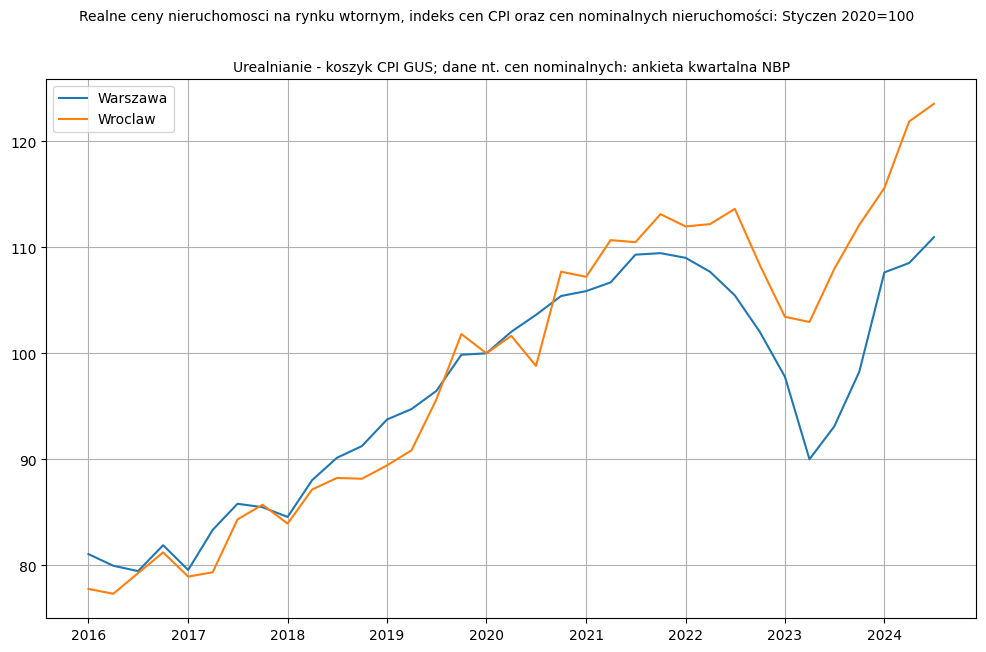

In [160]:
fig_real_price = plt.figure(figsize=(12, 7))
ax_rp = fig_real_price.add_subplot(1, 1, 1)
ax_rp.plot(data["index_warsaw_real"]*100, label="Warszawa")
ax_rp.plot(data["index_wroclaw_real"]*100, label="Wroclaw")
ax_rp.grid()
ax_rp.legend()
ax_rp.set_title("Urealnianie - koszyk CPI GUS; dane nt. cen nominalnych: ankieta kwartalna NBP", size=10)
fig_real_price.suptitle("Realne ceny nieruchomosci na rynku wtornym, indeks cen CPI oraz cen nominalnych nieruchomości: Styczen 2020=100", size=10)

### 5. Index of Real Gold Price (XAUPLN Corrected with GUS CPI Inflation) 

In [196]:
xaupln = pd.read_csv(
    Path(os.getcwd()).parent / "data" / "xaupln_d.csv",
    decimal=".",
    sep=","
)
xaupln["Date"] = pd.to_datetime(xaupln["Date"])
xaupln = xaupln.set_index("Date")
xaupln = xaupln[["Close"]]
xaupln = xaupln["2016-01-01":]

In [197]:
xaupln["Close_index"] = xaupln["Close"] / xaupln.at["2020-01-02", "Close"]

In [198]:
xaupln = pd.merge(
    left=xaupln["Close_index"],
    right=inflation[["price_level"]],
    left_index=True,
    right_index=True,
    how="left"
)


In [200]:
xaupln["price_level"] = xaupln["price_level"].ffill().bfill()

In [201]:
xaupln["gold_real_price_index"] = xaupln["Close_index"] / xaupln["price_level"]

Text(0.5, 0.98, 'Indeks Realnej ceny złota, początek roku 2020=100')

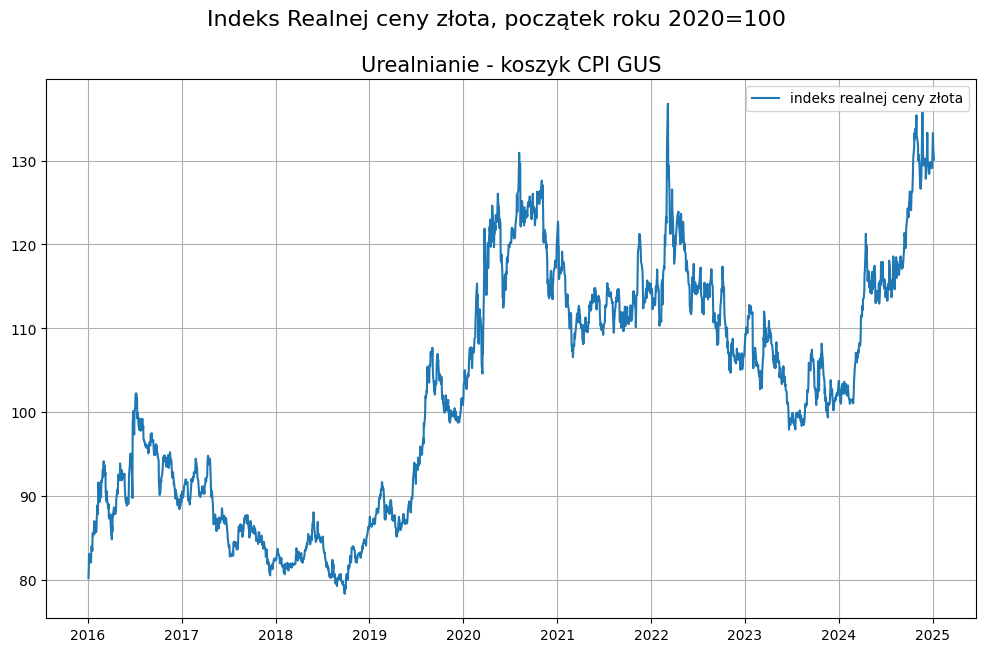

In [204]:
fig_gold_real_price = plt.figure(figsize=(12, 7))
ax_gold = fig_gold_real_price.add_subplot(1, 1, 1)
ax_gold.plot(xaupln["gold_real_price_index"]*100, label="indeks realnej ceny złota")
ax_gold.grid()
ax_gold.legend()
ax_gold.set_title("Urealnianie - koszyk CPI GUS", size=15)
fig_gold_real_price.suptitle("Indeks Realnej ceny złota, początek roku 2020=100", size=16)